In [52]:
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

torch.set_warn_always(False)

In [7]:
class LinearLayer(nn.Module) : 
    def __init__(self, in_features, out_features) : 
        super(LinearLayer, self).__init__()
        self.in_features = in_features 
        self.out_features = out_features
        self.w = nn.Parameter(torch.randn(in_features, out_features)) # required_grad = True 
        self.b = nn.Parameter(torch.randn(out_features))

    # backward is taken care 
    def forward(self, x) : 
        out = torch.matmul(x, self.w) + self.b

model = LinearLayer(100, 10)

In [2]:
X = datasets.MNIST('data', train = True, download = True, transform = transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 846886.47it/s] 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 41086.79it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 429738.70it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7349741.04it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
print(X.classes)
print(X.data.shape)
print((X.targets.shape))

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([60000])


In [34]:
X_train, y_train = X.data[:1000], X.targets[:1000]
X_train = X_train.type(torch.float32)
X_train = X_train/X_train.max() # normalization

In [35]:
model = nn.Linear(in_features=784, out_features=10, bias=True)
print(model)
print(callable(model))

Linear(in_features=784, out_features=10, bias=True)
True


In [36]:
w, b = list(model.parameters())
print(w.shape, b.shape)

torch.Size([10, 784]) torch.Size([10])


In [37]:
print(w.grad)
print(torch.is_tensor(w))

None
True


In [38]:
out = model(X_train[0].reshape(1, 784))
print(out)

tensor([[-0.0897, -0.2854, -0.1796, -0.3914,  0.3842,  0.0797, -0.4325, -0.0329,
          0.0989, -0.1706]], grad_fn=<AddmmBackward0>)


In [39]:
y_hat = torch.softmax(out, dim = 1)
print(y_hat)

tensor([[0.0984, 0.0809, 0.0899, 0.0728, 0.1580, 0.1165, 0.0698, 0.1041, 0.1188,
         0.0907]], grad_fn=<SoftmaxBackward0>)


In [40]:
print(f"Predicted : {y_hat.argmax(dim=1)}")
print(f"GT : {y_train[0]}")

Predicted : tensor([4])
GT : 5


In [41]:
criterion = nn.CrossEntropyLoss()
loss = criterion(y_hat, y_train[0].reshape(1))
print(loss)

tensor(2.2864, grad_fn=<NllLossBackward0>)


In [42]:
optimizer = optim.SGD(model.parameters(), lr = 0.1)

In [43]:
loss.backward()

In [45]:
grad = np.array(w.grad.detach())
print(grad.shape)

(10, 784)


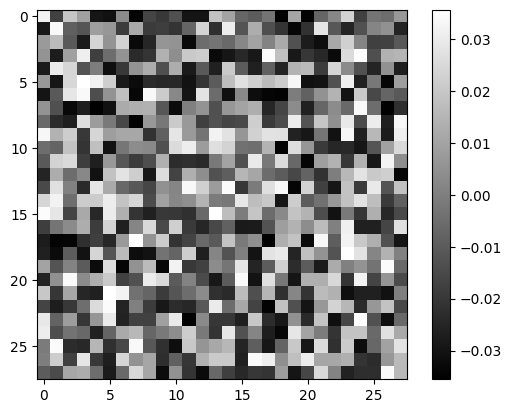

In [46]:
# plot weights 
weights = w.detach().numpy()
plt.imshow(weights[1, :].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

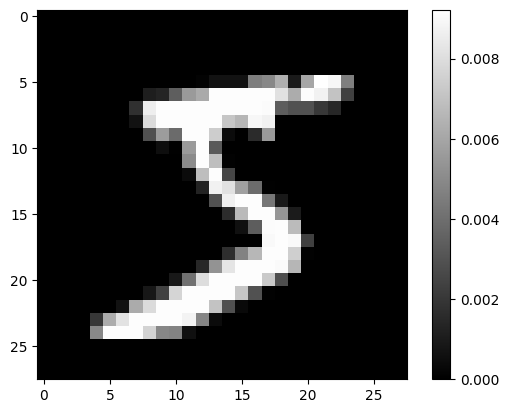

In [47]:
plt.imshow(grad[1, :].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

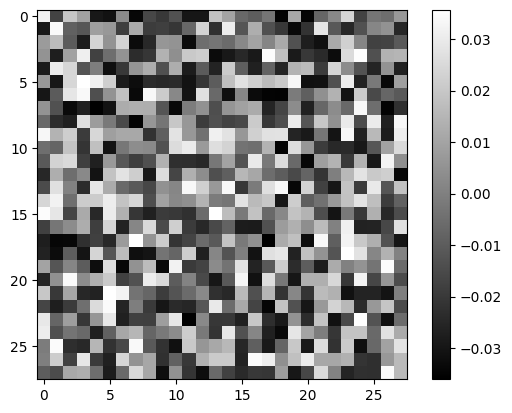

In [48]:
optimizer.step() # updates the weights 

# plot weights after 1 itr
weights = w.detach().numpy()
plt.imshow(weights[1, :].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [49]:
optimizer.zero_grad() # set accumulated gradient to zero 

#### 2 layer NN

In [51]:
# 1 liner 
model = nn.Sequential(
    nn.Linear(28*28, 20), nn.Sigmoid(), 
    nn.Linear(20, 10), nn.Sigmoid(), 
    nn.Softmax()
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): Sigmoid()
  (4): Softmax(dim=None)
)


In [53]:
# structured way 
class FFN(nn.Module) : 
    def __init__(self) :
        super(FFN, self).__init__() 
        self.a1 = nn.Linear(28*28, 20)
        self.a2 = nn.Linear(20, 10)

    def forward(self, x) : 
        h1 = torch.sigmoid(self.a1(x.reshape(1, 784)))
        h2 = torch.sigmoid(self.a2(h1))
        y_hat = F.softmax(h2, dim = 1)

        return y_hat 

In [99]:
epochs = 100 
model = FFN()
optimizer = optim.SGD(model.parameters(), lr = 0.2)

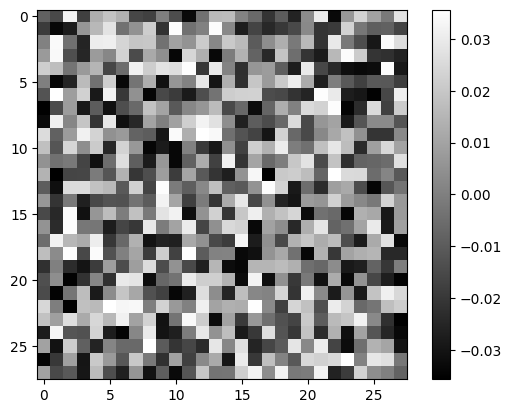

In [100]:
w1, b1, w2, b2 = list(model.parameters())
weights = w1.detach().numpy()
plt.imshow(weights[1,:].reshape(28, 28), cmap = 'gray')
plt.colorbar()
plt.show()

In [101]:
def train(X_train, model, optimizer) : 
    loss_trace, batch_size = [], 100
    for epoch in range(epochs) : 
        for i in range(len(X_train)) : 
            out = model(X_train[i])
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y_train[i].reshape(1))
            loss.backward()

        loss_trace.append(loss.detach().item())
        if epoch%10 == 0 :
            print(f"Epoch : {epoch}, loss : {loss.detach().item()}")
        optimizer.step()
        optimizer.zero_grad

    return loss_trace

In [102]:
loss_trace = train(X_train, model, optimizer)

Epoch : 0, loss : 2.2883141040802
Epoch : 10, loss : 2.181467294692993
Epoch : 20, loss : 2.1716363430023193
Epoch : 30, loss : 2.1730105876922607
Epoch : 40, loss : 2.171626329421997
Epoch : 50, loss : 2.1716220378875732
Epoch : 60, loss : 2.1716220378875732
Epoch : 70, loss : 2.1716220378875732
Epoch : 80, loss : 2.1716220378875732
Epoch : 90, loss : 2.1716220378875732


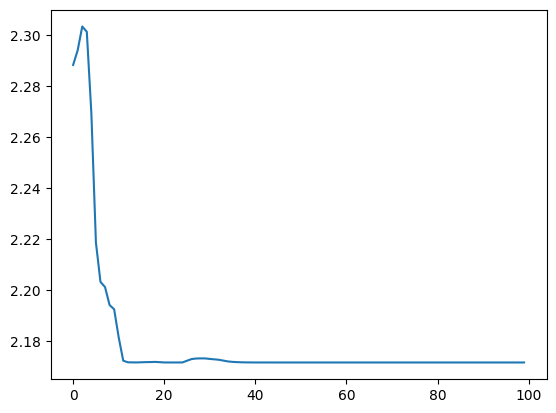

In [103]:
plt.plot(loss_trace)
plt.show()

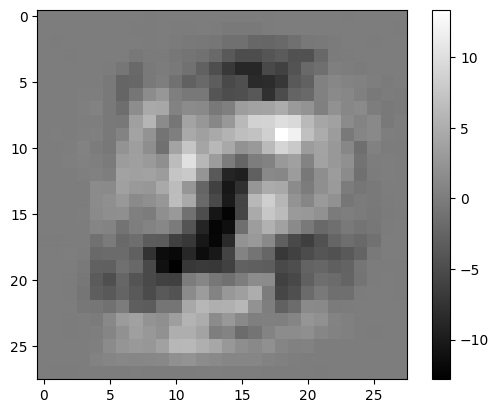

In [104]:
w1, b1, w2, b2 = list(model.parameters())
weights = w1.detach().numpy()
plt.imshow(weights[3,:].reshape(28, 28), cmap = 'gray')
plt.colorbar()
plt.show()